<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [12]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [13]:
# Hyperparameters
hidden_size = 60
embedding_dim = 40
seq_length = 25
learning_rate = 0.001
batch_size = 20
deep_num = 2
dropout_prob = 0.1

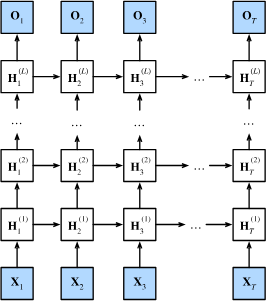

as illustrated by the above graph.
we could define the layers of the rnn as deep_num
and every hidden state is decided by the pre step hidden state and the lower layers hidden state.

let us implement this structure.

from what I understand, If the RNN is deep, let say 3 layers, then the performance of the model should be better?

but the result is a little disappointing. dont know why

So I update the deepRNN again.

Let see the result

In [10]:
l = torch.ones([4,2,3])
B,T,_ = l.shape
print(B)
print(T)

4
2


In [35]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.layer_norm = nn.LayerNorm(hidden_size)

  def forward(self, pre_h_list):
    h_list = []
    h = torch.zeros_like(pre_h_list[:, 0, :])  # Initial hidden state
    for i in range(pre_h_list.size(1)):
      h = torch.tanh(self.layer_norm(self.i2h(pre_h_list[:, i, :]) + self.h2h(h)))
      h_list.append(h)
    return torch.stack(h_list, dim=1)


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size)
    self.rnn_list = nn.ModuleList([SimpleRNN(hidden_size) for _ in range(deep_num)])
    self.h2o = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(dropout_prob)
  def forward(self, x):
    x = self.embedding(x)
    B,T,C = x.shape
    h = self.e2h(x)
    for i in range(self.deep_num):
      h = self.rnn_list[i](h)
      h = self.dropout(h)
    y = self.h2o(h)
    return y

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

I updated the VanillaRNN a little, since We dont need the output of the intermediate node in Deep RNN, so we could remove the self.h2o linear layer. and add an final linear layer in the upper layer, by doing so, we could significantly reduce the amount of the parameters in the nn.

In [16]:
def generateMiniBatch(start_idx):
  batch_inputs = []
  batch_targets = []

  # Generate examples for the current minibatch
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets

In [29]:
stopi = []
lossi = []

In [ ]:
# Training loop
num_iterations = 2 * 1000000
p = 0
for iteration in range(num_iterations):

  if p + seq_length + 1 > len(data):
    p = 0;

  inputs, targets = generateMiniBatch(p)

  optimizer.zero_grad()

  predict_char = model(inputs)

  B,T = targets.shape

  loss = criterion(predict_char.view(B*T, -1), targets.view(B*T))

  loss.backward()

  for param in model.parameters():
    if param.grad is not None:
      param.grad.data.clamp_(-5, 5)

  optimizer.step()

  if iteration % 1000 == 0:
    print(f'Iteration {iteration}, Loss: {loss.item()}')
    stopi.append(iteration)
    lossi.append(loss.item())

  p += seq_length  # Move data pointer

Iteration 0, Loss: 2.482011079788208
Iteration 1000, Loss: 2.1980128288269043


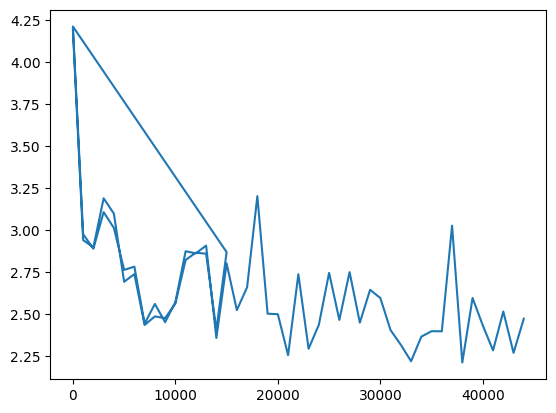

In [37]:
plt.plot(stopi, lossi)

In [60]:
# Sample from the model
x = torch.tensor(char_to_ix[data[0]], dtype=torch.long).view(1, 1)
ixes = []
ixes.append(ix_to_char[x[0][0].item()])

n = 2000

for _ in range(n):
  inputs = torch.tensor([char_to_ix[ch] for ch in ixes[-seq_length:]], dtype=torch.long).view(1, -1)
  outputs = model(inputs)
  outputs = outputs[:,-1,:]
  p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
  ix = np.random.choice(range(vocab_size), p=p)
  y = torch.tensor(ix, dtype=torch.long).view(1, 1)

  ixes.append(ix_to_char[y[0][0].item()])

print(''.join(ixes))

Fid, heuty Llut pathof meutasp saitjm
Aelga be ke thon todwtel!
I peo.
doS kicossen thal ia so; tharer, tore sh d;to.Bf YIthnd?
IOUW picy
And:
Bewon pool ferith
Fragf, abdit; wouv lyekes:
Zivate dorcou lind th rirs ant mrurethasre the a
$hi'y
IO RMCS.TR, mbito roMI, wace mt mear.
Uhh $uches weonm.
Hy the nodel, iind iwde nmums ohe.
yg axe th tnchensthreis seett,iperwy fingi?:
dion't ivW tead thes nole ach Nhinr;
O weavinverBocy fe, to lort Fis, me the cene ue if woot mU
Youy sanc p:era, rom me and
Ov!
.

R werw, c3alrou dlof to:

NLbY avi.
G,rLase mum fey candy a shon or Wish, parnin hy.E ca
oow on to yiugts comdrisH net I tor'd me diach
AnA:$too ghitusd AriveW uhe ard tyI

WendT'd bedosd be, to.

LIH
KTCThe are: hssyles-lpcicondors s ive ppoV!ow, an?,
Ius heer atincarcasno satI, atee!

BNAMOROBSTUMERUUKS
CRes whin Zcome yot I wuth te there ,ume ciciurSiy opMdeot thassep ea hebet yuprgp.us, ahy NTn!nhrme goujkehe s-roY hsyNersch thee thin? thein nos nce awin cor,-yous d nyVona fo parte